In [5]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import xarray as xr
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
import seaborn_image as isns
import calendar
import string

In [6]:
import plotly.io as pio
pio.renderers.default='jupyterlab'

In [7]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [8]:
mesh_mask = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/masks/mesh_mask.nc')

In [9]:
mask = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/masks/tmaskm.nc')

In [10]:
mask = mask.tmask.isel(time=0)

In [11]:
# calculate volume for each grid cell

dx = mesh_mask.e1t 
dy = mesh_mask.e2t
grid_cell_area = dx * dy # m2

In [12]:
gridded_mesh = grid_cell_area.isel(t=0)

In [13]:
# apply mask to weighted grid cells

ocean_area = gridded_mesh * mask

In [14]:
ocean_area_sliced = ocean_area.sel(x=slice(520,595),y=slice(330,435),z=0)
ocean_area_sliced_dp = ocean_area_sliced.isel(x=slice(58,60),y=slice(41,43))

In [15]:
base_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_baseline_2.6_weighted.nc', decode_times=True)
oae_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_oae_2.6_weighted.nc', decode_times=True)

base_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/co2flux_baseline_7.0_weighted.nc', decode_times=True)
oae_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/co2flux_oae_7.0_weighted.nc', decode_times=True)

base_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_Baseline_2.6_cropped.nc', decode_times=True)
oae_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_OAE_2.6_cropped.nc', decode_times=True)

base_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/CO2flux_Baseline_7.0_cropped.nc', decode_times=True)
oae_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/CO2flux_OAE_7.0_cropped.nc', decode_times=True)

In [16]:
base_dp_26 = base_dp_26.isel(x=slice(58,60),y=slice(41,43),time=0)
oae_dp_26 = oae_dp_26.isel(x=slice(58,60),y=slice(41,43),time=0)
base_dp_70 = base_dp_70.isel(x=slice(58,60),y=slice(41,43),time=0)
oae_dp_70 = oae_dp_70.isel(x=slice(58,60),y=slice(41,43),time=0)

In [17]:
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [18]:
def annualavg(co2flux):
    co2flux = co2flux.sel(time_counter=slice('2090','2100'))
    co2flux = (co2flux.co2flux * 31536000 * ocean_area_sliced / 3.6667).to_dataset(name='co2flux') # kg/m2/yr CO2
    co2flux = co2flux.sum(['x','y'])
    month_length_baseline = co2flux.time_counter.dt.days_in_month
    co2flux = ((co2flux * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum())
    co2flux = co2flux.isel(time=0)
    co2flux = co2flux.to_dataframe()
    co2flux['Month'] = pd.DatetimeIndex(co2flux.index).month
    conditions_month_co2flux = [
        (co2flux['Month'] == 1),
        (co2flux['Month'] == 2),
        (co2flux['Month'] == 3),
        (co2flux['Month'] == 4),
        (co2flux['Month'] == 5),
        (co2flux['Month'] == 6),
        (co2flux['Month'] == 7),
        (co2flux['Month'] == 8),
        (co2flux['Month'] == 9),
        (co2flux['Month'] == 10),
        (co2flux['Month'] == 11),
        (co2flux['Month'] == 12)
        ]
    values_month_co2flux = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    co2flux['Month'] = np.select(conditions_month_co2flux, values_month_co2flux)
    co2flux = (co2flux.groupby(co2flux.index.month).mean()).reset_index()
    co2flux['time_counter'] = co2flux['time_counter'].apply(lambda x: calendar.month_abbr[x])
    colors_month_co2flux = dict(zip(co2flux.time_counter.unique(), ['powderblue', 'darkcyan', 'forestgreen', 'darkseagreen', 
                                                        'honeydew', 'bisque', 'khaki', 'gold', 
                                                        'sandybrown', 'lightcoral', 'chocolate', 'cadetblue']))
    
# def comp(oae, baseline):
#     delta = (oae.co2flux - baseline.co2flux).to_xarray()
#     delta = delta.to_dataframe('co2flux')
#     delta = (delta.groupby(delta.index.month).co2flux.mean()).reset_index()
#     delta['time_counter'] = delta['time_counter'].apply(lambda x: calendar.month_abbr[x])

In [19]:
def annualavg_dp(co2flux):
    co2flux = co2flux.sel(time_counter=slice('2090','2100'))
    co2flux = (co2flux.co2flux * 31536000 * ocean_area_sliced_dp / 3.6667).to_dataset(name='co2flux') # kg/m2/yr CO2
    co2flux = co2flux.sum(['x', 'y'])
    month_length_baseline = co2flux.time_counter.dt.days_in_month
    co2flux = ((co2flux * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum())
    co2flux = co2flux.to_dataframe()
    co2flux['Month'] = pd.DatetimeIndex(co2flux.index).month
    conditions_month_co2flux = [
        (co2flux['Month'] == 1),
        (co2flux['Month'] == 2),
        (co2flux['Month'] == 3),
        (co2flux['Month'] == 4),
        (co2flux['Month'] == 5),
        (co2flux['Month'] == 6),
        (co2flux['Month'] == 7),
        (co2flux['Month'] == 8),
        (co2flux['Month'] == 9),
        (co2flux['Month'] == 10),
        (co2flux['Month'] == 11),
        (co2flux['Month'] == 12)
        ]
    values_month_co2flux = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    co2flux['Month'] = np.select(conditions_month_co2flux, values_month_co2flux)
    co2flux = (co2flux.groupby(co2flux.index.month).mean()).reset_index()
    co2flux['time_counter'] = co2flux['time_counter'].apply(lambda x: calendar.month_abbr[x])
    colors_month_co2flux = dict(zip(co2flux.time_counter.unique(), ['powderblue', 'darkcyan', 'forestgreen', 'darkseagreen', 
                                                        'honeydew', 'bisque', 'khaki', 'gold', 
                                                        'sandybrown', 'lightcoral', 'chocolate', 'cadetblue']))

In [20]:
annualavg(base_eu_26)
annualavg(oae_eu_26)
annualavg(base_eu_70)
annualavg(oae_eu_70)
annualavg_dp(base_dp_26)
annualavg_dp(oae_dp_26)
annualavg_dp(base_dp_70)
annualavg_dp(oae_dp_70)

In [21]:
base_eu_26 = base_eu_26.isel(time=0)
oae_eu_26 = oae_eu_26.isel(time=0)
delta_eu_26 = (oae_eu_26.co2flux - base_eu_26.co2flux)

delta_eu_26 = delta_eu_26.to_dataframe('co2flux')
delta_eu_26_mean = (delta_eu_26.groupby(delta_eu_26.index.month).co2flux.mean()).reset_index()
delta_eu_26_mean['time_counter'] = delta_eu_26_mean['time_counter'].apply(lambda x: calendar.month_abbr[x])

In [22]:
base_eu_70 = base_eu_70.isel(time=0)
oae_eu_70 = oae_eu_70.isel(time=0)
delta_eu_70 = (oae_eu_70.co2flux - base_eu_70.co2flux)

delta_eu_70 = delta_eu_70.to_dataframe('co2flux')
delta_mean_eu_70 = (delta_eu_70.groupby(delta_eu_70.index.month).co2flux.mean()).reset_index()
delta_mean_eu_70['time_counter'] = delta_mean_eu_70['time_counter'].apply(lambda x: calendar.month_abbr[x])

In [23]:
delta_dp_26 = (oae_dp_26.co2flux - base_dp_26.co2flux)
delta_dp_26 = delta_dp_26.to_dataframe('co2flux').set_index('time_centered')
delta_mean_dp_26 = (delta_dp_26.groupby(delta_dp_26.index.month).co2flux.mean()).reset_index()
delta_mean_dp_26['time_centered'] = delta_mean_dp_26['time_centered'].apply(lambda x: calendar.month_abbr[x])

In [31]:
delta_dp_70 = (oae_dp_70.co2flux - base_dp_70.co2flux)

delta_dp_70 = delta_dp_70.to_dataframe('co2flux').set_index('time_centered')
delta_mean_dp_70 = (delta_dp_70.groupby(delta_dp_70.index.month).co2flux.mean()).reset_index()
delta_mean_dp_70['time_centered'] = delta_mean_dp_70['time_centered'].apply(lambda x: calendar.month_abbr[x])

In [36]:
base_eu_26 = base_eu_26
base_eu_70
base_dp_26
base_dp_70 

<xarray.Dataset>
Dimensions:        (y: 2, x: 2, time_counter: 1020)
Coordinates:
    time           float64 0.0
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...
Dimensions without coordinates: y, x
Data variables:
    co2flux        (y, x, time_counter) float64 ...

AttributeError: 'DataArray' object has no attribute 'map'

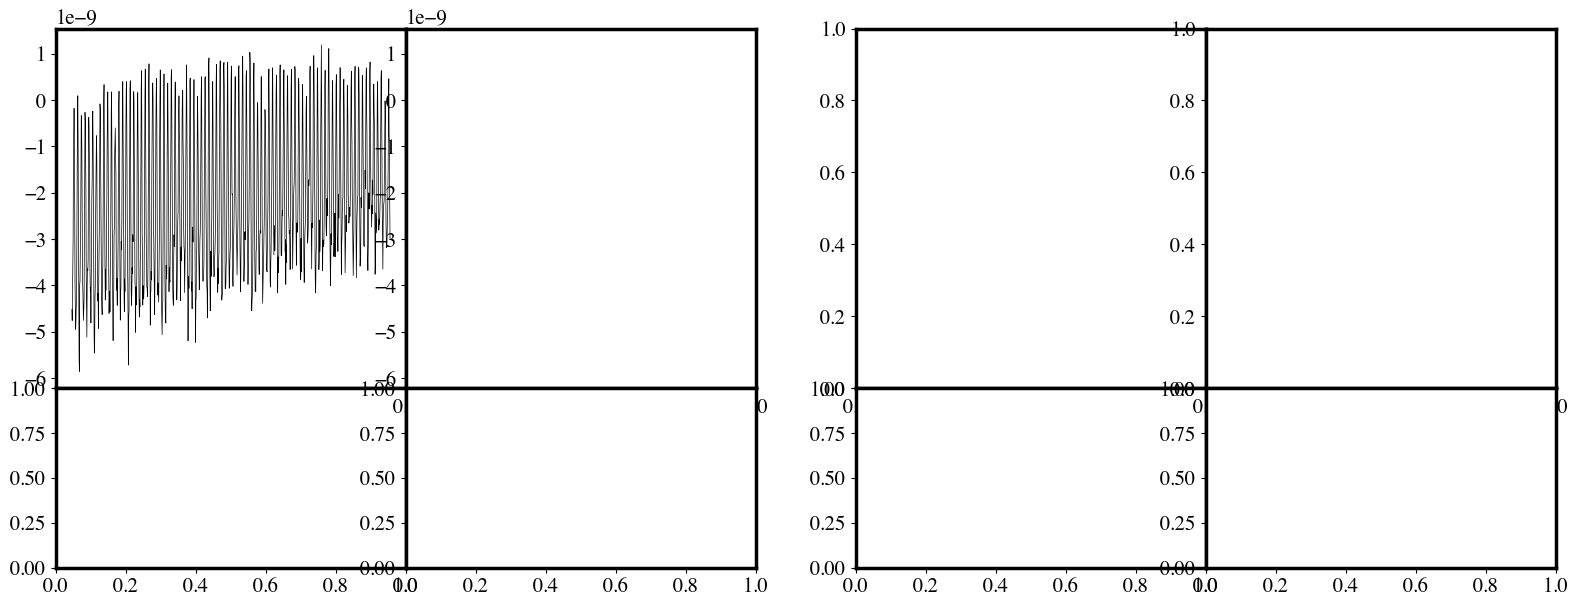

In [32]:
f = plt.figure(figsize=(20, 7)) 
gs_left = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])
gs_right = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])

ax1 = plt.subplot(gs_left[0,0])
ax2 = plt.subplot(gs_left[1,0])
ax3 = plt.subplot(gs_left[0,1], sharey = ax1)
ax4 = plt.subplot(gs_left[1,1], sharey = ax2)
ax5 = plt.subplot(gs_right[0,2])
ax6 = plt.subplot(gs_right[1,2])
ax7 = plt.subplot(gs_right[0,3], sharey = ax5)
ax8 = plt.subplot(gs_right[1,3], sharey = ax6)

gs_left.update(wspace=0, hspace=0, left=0, right=0.7)
gs_right.update(wspace=0, hspace=0, left=0.05, right=0.75)

ax1.plot(base_eu_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax1.scatter(base_eu_26.time_counter, base_eu_26.co2flux, color=base_eu_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax1.plot(oae_eu_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax1.scatter(oae_eu_26.time_counter, oae_eu_26.co2flux, color=oae_eu_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.plot(delta_mean_eu_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax2.scatter(delta_mean_eu_26.time_counter, delta_mean_eu_26.co2flux, color=delta_mean_eu_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax3.plot(eu_70_baseline_co2flux.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax3.scatter(eu_26_baseline_co2flux.time_counter, eu_70_baseline_co2flux.co2flux, color=eu_70_baseline_co2flux.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax3.plot(eu_70_oae_co2flux.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax3.scatter(eu_70_oae_co2flux.time_counter, eu_70_oae_co2flux.co2flux, color=eu_70_oae_co2flux.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax3.tick_params(axis='y', which='major', labelsize=12)

ax4.plot(delta_co2flux_mean_eu_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax4.scatter(delta_co2flux_mean_eu_70.time_counter, delta_co2flux_mean_eu_70.co2flux, color=delta_co2flux_mean_eu_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax5.plot(dp_26_baseline_co2flux.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax5.scatter(dp_26_baseline_co2flux.time_counter, dp_26_baseline_co2flux.co2flux, color=dp_26_baseline_co2flux.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax5.plot(dp_26_oae_co2flux.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax5.scatter(dp_26_oae_co2flux.time_counter, dp_26_oae_co2flux.co2flux, color=dp_26_oae_co2flux.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax5.tick_params(axis='y', which='major', labelsize=12)

ax6.plot(delta_co2flux_mean_dp_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax6.scatter(delta_co2flux_mean_dp_26.time_counter, delta_co2flux_mean_dp_26.co2flux, color=delta_co2flux_mean_dp_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax7.plot(dp_70_baseline_co2flux.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax7.scatter(dp_70_baseline_co2flux.time_counter, dp_70_baseline_co2flux.co2flux, color=dp_70_baseline_co2flux.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax7.plot(dp_70_oae_co2flux.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax7.scatter(dp_70_oae_co2flux.time_counter, dp_70_oae_co2flux.co2flux, color=dp_70_oae_co2flux.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax7.tick_params(axis='y', which='major', labelsize=12)

ax8.plot(delta_co2flux_mean_dp_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax8.scatter(delta_co2flux_mean_dp_70.time_counter, delta_co2flux_mean_dp_70.co2flux, color=delta_co2flux_mean_dp_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.tick_params(axis='y', which='major', labelsize=12)
for n, ax in enumerate(axes):
    ax.text(0.9, 0.9, string.punctuation[7] + ' ' + string.ascii_uppercase[n], transform=ax.transAxes, 
            size=14, weight='bold', color='black')

ax1.set_ylabel('CO2 flux [mol/m2/yr]', fontsize=14)
ax2.set_ylabel('Δ CO2 flux', fontsize=14)
ax5.set_ylabel('CO2 flux [mol/m2/yr]', fontsize=14)
ax6.set_ylabel('Δ CO2 flux', fontsize=14)

# ax1.text(0, -1, s='Baseline', fontsize=14)
# ax1.text(0, -3.5, s='OAE', fontsize=14)
# ax3.text(0, -2, s='Baseline', fontsize=14)
# ax3.text(0, -6, s='OAE', fontsize=14)
# ax5.text(0, 1, s='Baseline', fontsize=14)
# ax5.text(0, -12, s='OAE', fontsize=14)
# ax7.text(0, 1, s='Baseline', fontsize=14)
# ax7.text(0, -18, s='OAE', fontsize=14)

# start2, end2 = ax2.set_ylim(-5, -1)
# ax2.yaxis.set_ticks(np.arange(start2+1, end2, 1))
# start5, end5 = ax5.set_ylim(-40, 5)
# ax5.yaxis.set_ticks(np.arange(start5+5, end5, 10))
# start6, end6 = ax6.set_ylim(-35, 0)
# ax6.yaxis.set_ticks(np.arange(start6+5, end6, 10))

axtick = [ax3, ax4, ax7, ax8]
for ax in axtick:
    ax.yaxis.set_tick_params(labelleft=False)
    
axline = [ax1, ax3, ax5, ax7]
for ax in axline:
    ax.axhline(0, color='black', linewidth=0.5)
    
ax.text(-38.5,7, 'European average - SSP1_2.6')
ax.text(-26.5,7, 'European average - SSP3_7.0')
ax.text(-10,7, 'Location S - SSP1_2.6')
ax.text(2,7, 'Location S - SSP3_7.0')

legend = [mpatches.Circle((0.5, 0.5), 1, facecolor = value, edgecolor = "black", linewidth=0.5, label = key, alpha = 1) for key, value in colors_month_co2flux.items()]
ax.legend(handles = legend, bbox_to_anchor=(-2.28,1.45), loc='best', columnspacing=0.05, handletextpad=0.4, fontsize=14, ncol = 4, handler_map={mpatches.Circle: HandlerEllipse()})

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/finals/co2flux.png')

In [2]:
eu_26_baseline_mean = (eu_26_baseline_co2flux['co2flux'] - eu_26_baseline_co2flux['co2flux'].mean()).to_xarray()
eu_26_oae_mean =(eu_26_oae_co2flux['co2flux'] - eu_26_oae_co2flux['co2flux'].mean()).to_xarray()

NameError: name 'eu_26_baseline_co2flux' is not defined

In [3]:
eu_70_baseline_mean =(eu_70_baseline_co2flux['co2flux'] - eu_70_baseline_co2flux['co2flux'].mean()).to_xarray()
eu_70_oae_mean =(eu_70_oae_co2flux['co2flux'] - eu_70_oae_co2flux['co2flux'].mean()).to_xarray()

NameError: name 'eu_70_baseline_co2flux' is not defined

In [4]:
dp_26_baseline_mean = (dp_26_baseline_co2flux['co2flux'] - dp_26_baseline_co2flux['co2flux'].mean()).to_xarray()
dp_26_oae_mean =(dp_26_oae_co2flux['co2flux'] - dp_26_oae_co2flux['co2flux'].mean()).to_xarray()

NameError: name 'dp_26_baseline_co2flux' is not defined

In [15]:
dp_70_baseline_mean =(dp_70_baseline_co2flux['co2flux'] - dp_70_baseline_co2flux['co2flux'].mean()).to_xarray()
dp_70_oae_mean =(dp_70_oae_co2flux['co2flux'] - dp_70_oae_co2flux['co2flux'].mean()).to_xarray()

In [16]:
eu_26_baseline_mean = eu_26_baseline_mean.to_dataframe(name='co2flux')
eu_26_oae_mean = eu_26_oae_mean.to_dataframe(name='co2flux')

In [17]:
mean_co2flux = [
    (eu_26_baseline_mean.index == 0),
    (eu_26_baseline_mean.index == 1),
    (eu_26_baseline_mean.index == 2),
    (eu_26_baseline_mean.index == 3),
    (eu_26_baseline_mean.index == 4),
    (eu_26_baseline_mean.index == 5),
    (eu_26_baseline_mean.index == 6),
    (eu_26_baseline_mean.index == 7),
    (eu_26_baseline_mean.index == 8),
    (eu_26_baseline_mean.index == 9),
    (eu_26_baseline_mean.index == 10),
    (eu_26_baseline_mean.index == 11),
]

values_mean_co2flux = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

In [18]:
colors_mean = dict(zip(eu_26_baseline_mean.index.unique(), ['powderblue', 'darkcyan', 'forestgreen', 'darkseagreen', 
                                                        'honeydew', 'bisque', 'khaki', 'gold', 
                                                        'sandybrown', 'lightcoral', 'chocolate', 'cadetblue']))

In [19]:
eu_26_baseline_mean.index = np.select(mean_co2flux, values_mean_co2flux)

In [20]:
eu_26_oae_mean.index = np.select(mean_co2flux, values_mean_co2flux)

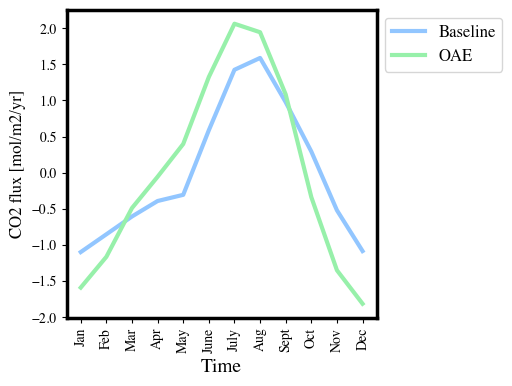

In [21]:
plt.figure(figsize=(4, 4))
plt.plot(eu_26_baseline_mean.index, eu_26_baseline_mean.co2flux, linewidth=3, label = 'Baseline')
plt.plot(eu_26_oae_mean.index, eu_26_oae_mean.co2flux, linewidth=3, label = 'OAE')
plt.xlabel("Time", fontsize=14)
plt.ylabel("CO2 flux [mol/m2/yr]", fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), loc='best', fontsize=12)
plt.tick_params(axis='x', which='major', labelsize=10, rotation=90)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.title('', fontname="Times", fontsize=12, y=1.06)
plt.show()